## Flatiron Capstone Project: Automated Breast Cancer Metastasis Detection

### Results & Visualizations

#### Marissa Eppes

**SUMMARY:** This notebook tests and reports the results of the best Convolutional Neural Network (CNN) Image Classifier as determined in the "Convolutional Neural Network Development" notebook according to validation accuracy.

The notebook also shows example heatmap outputs, which are constructed using the visualizations.py module. 

In [1]:
# Import necessary libraries

import predict as p
import visualizations as v
import keras
from keras.models import load_model
from keras import models
import glob
from PIL import Image
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Results

The plot below graphs the training and validation accuracies for the final model as a function of number of epochs. As the model approaches 40 epochs, we can see the training accuracy rise above the validation accuracy, indicating over-fitting. At this point, Image Augmentation (randomly flipping and rotating training data to increase generalizability) is introduced. This technique drops the training accuracy back down toward the validation accuracy, which is desirable for keeping the model "honest". However, we can see that both accuracies continue to steadily increase, indicating that this technique is beneficial to the model. It should be noted that Image Augmentation is not introduced from the beginning due to time and resource constraints - An Image Augmentation epoch takes ~10x longer to train than a regular epoch. The highest accuracy occurs at 58 epochs. Therefore weights for the final predictive model will be taken from this epoch.

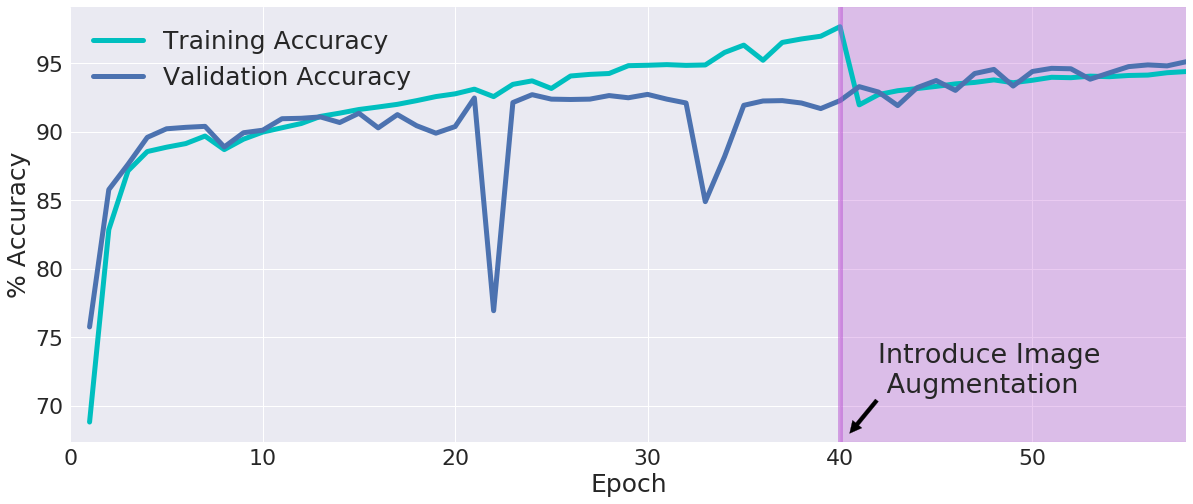

In [4]:
v.make_training_log_plot()

The purpose of the following cell is to determine an approximate natural ratio of Non-Cancer:Cancer tiles. All available tile data is gathered for both classes (training and testing) and counted to determine a testing ratio. The calculated ratio is ~9:1 non-cancer to cancer. It should be noted that:
* Training data is not used for testing in anyway. It is only used here to help calculate a cancer occurrence ratio.

* This ratio is a "best guess"based on the available data. The actual ratio that occurs in nature is not easily determined, and we do want to make sure that we do not under-represent the importance of detecting cancer. 

In [5]:
test_normal_glob = glob.glob('/home/ubuntu/test/normal_tiles/*/*jpeg')
test_cancer_glob = glob.glob('/home/ubuntu/test/cancer_tiles/*/*jpeg')
train_normal_glob = glob.glob('/home/ubuntu/tumor/normal_tiles/*/*jpeg')
train_cancer_glob = glob.glob('/home/ubuntu/tumor/cancer_tiles/*/*jpeg')
ratio_n_to_c = (len(test_normal_glob) + len(train_normal_glob)) / \
    (len(test_cancer_glob) + len(train_cancer_glob))
print(ratio_n_to_c)

9.139078796347123


### Testing

In [6]:
# A random sample of testing tiles is pulled from all testing WSI in the
# approximate 9:1 ratio, as previously determined.

np.random.seed(38)
random_normal_tiles = np.random.choice(test_normal_glob, size=45000)
random_cancer_tiles = np.random.choice(test_cancer_glob, size=5000)

In [7]:
# Loads the best model (Model 6, Epoch 58)

best_model = load_model(
    '/home/ubuntu/Notebooks/Final_Project/weights_6_final_6_aug.08-0.13.hdf5')

In [8]:
# Makes predictions on randomly chosen testing tiles

normal_predictions = p.predict(random_normal_tiles, best_model)
cancer_predictions = p.predict(random_cancer_tiles, best_model)

In [9]:
# Labels testing tiles by selecting the higher probability class

normal_prediction_labels = p.label(normal_predictions)
cancer_prediction_labels = p.label(cancer_predictions)

In [10]:
# Calculates correct predictions, as well as Type I and Type II errors

number_correct_normal, number_incorrect_normal = p.count_correct(
    normal_predictions, 0)
number_correct_cancer, number_incorrect_cancer = p.count_correct(
    cancer_predictions, 1)
print('True Negatives: ', number_correct_normal)
print('False Positives ', number_incorrect_normal)
print('True Positives: ', number_correct_cancer)
print('False Negatives: ', number_incorrect_cancer)

True Negatives:  38998
False Positives  6002
True Positives:  4482
False Negatives:  518


In [11]:
# Reports classification metrics for the model

accuracy = p.calculate_metric('accuracy', number_correct_cancer,
                              number_correct_normal, number_incorrect_cancer, number_incorrect_normal)
recall = p.calculate_metric('recall', number_correct_cancer,
                            number_correct_normal, number_incorrect_cancer, number_incorrect_normal)
precision = p.calculate_metric('precision', number_correct_cancer,
                               number_correct_normal, number_incorrect_cancer, number_incorrect_normal)
f1_score = p.calculate_metric('f1', number_correct_cancer, number_correct_normal,
                              number_incorrect_cancer, number_incorrect_normal)
print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('Precision: ', precision)
print('F1 Score: ', f1_score)

Accuracy:  0.8696
Recall:  0.8964
Precision:  0.4275085845097291
F1 Score:  0.5789201756652028


In [12]:
# Creates confusion matrix

truth = np.concatenate(
    [np.zeros(len(normal_predictions)), np.ones(len(cancer_predictions))])
predictions = np.concatenate(
    [normal_prediction_labels, cancer_prediction_labels])
cm = confusion_matrix(truth, predictions)

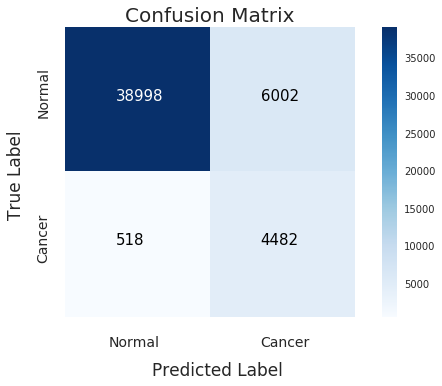

In [93]:
v.plot_confusion_matrix(cm, ['Normal', 'Cancer'])

In [92]:
# Displays confusion matrix as Pandas Dataframe

confusion_matrix = pd.DataFrame(data=[[number_correct_normal, number_incorrect_normal], [number_incorrect_cancer, number_correct_cancer]], columns=[
                                'predicted_normal', 'predicted_cancer'], index=['actual_normal', 'actual_cancer'])
confusion_matrix

,predicted_normal,predicted_cancer
actual_normal,38998,6002
actual_cancer,518,4482


### Discussion
The Recall metric is considered the most import metric for an application such as this one. Recall forgives false positives, as long as false negatives are kept minimal. This makes sense for a medical diagnosis application because we definitely do not want to miss cancer occurrences. We are okay with incorrectly predicting cancer some of the time if it increases our sensitivity to predicting true cancer.

That being said, this application is different from a straight diagnosis at the patient level. This model is essentially diagnosing a single piece of tissue at a time in order to produce a heatmap for further analysis. While we definitely care about Recall, we also care about Accuracy somewhat, as this indicates just how much we can rely on the heatmap to "paint the right picture."

The results indicate that this particular model aligns well with this line of thinking. The Recall score is ~90%, which is the highest score of all the calculated metrics. This is desirable, since we consider Recall to be the most important metric. The accuracy score is not far below Recall, coming in at ~87%. Since we do care about Accuracy considerably for this application, this is a desirable result.

Overall, this model provides a good baseline model, on which more data can be used to train and improve the performance of the model. Next, heatmaps will be created for a few test WSI to subjectively evaluate how the model is doing.

## Heatmaps

The following visualizations consist of heatmaps for a select few test WSI constructed based on model predictions. For each heatmap, the raw annotated WSI is shown directly below the heatmap. Comparing heatmaps to the raw data, we can see that the model outputs predictions comparable to annotations by pathologists. There is still work that can be done to improve the model, however, as we can see by the considerable amount of False Positive and Negative areas on some of the WSI. 

In [105]:
predictions_040 = v.predictions_for_heatmap('test_040', best_model)
predictions_021 = v.predictions_for_heatmap('test_021', best_model)
predictions_027 = v.predictions_for_heatmap('test_027', best_model)

### Test WSI #40

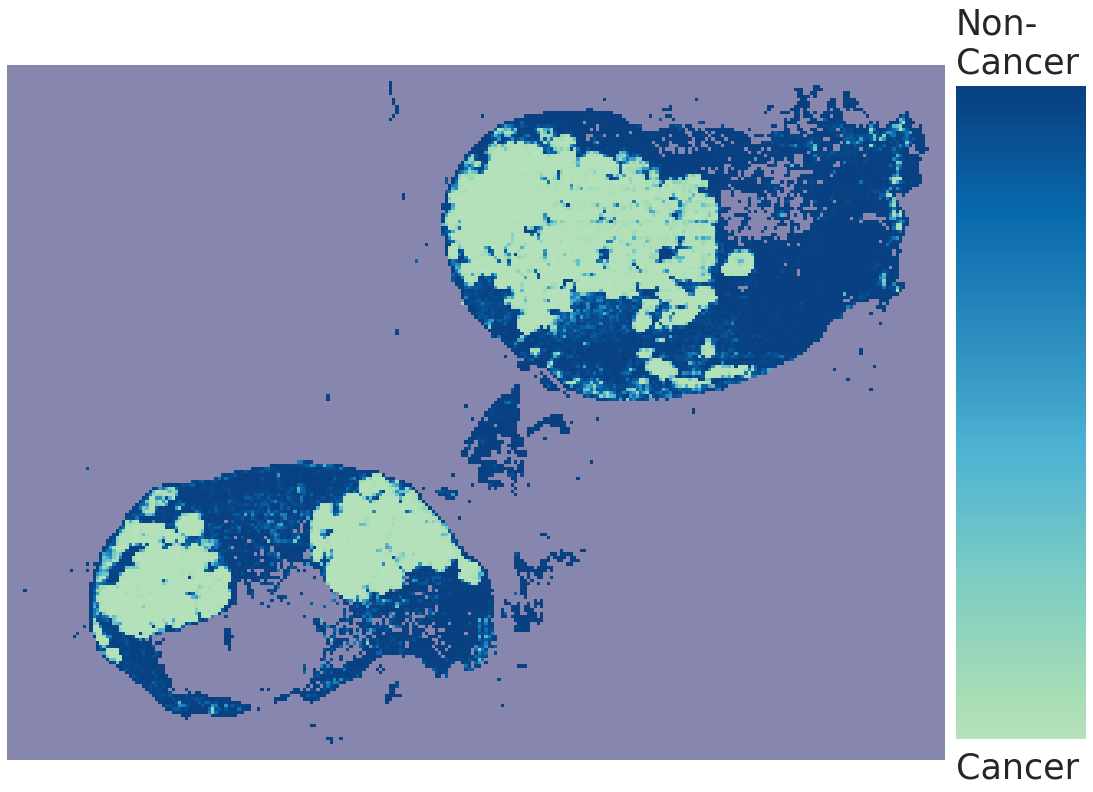

In [129]:
v.make_heatmap('test_040', predictions_040, 56,
               shrink=.6, aspect=5, rotate=False)

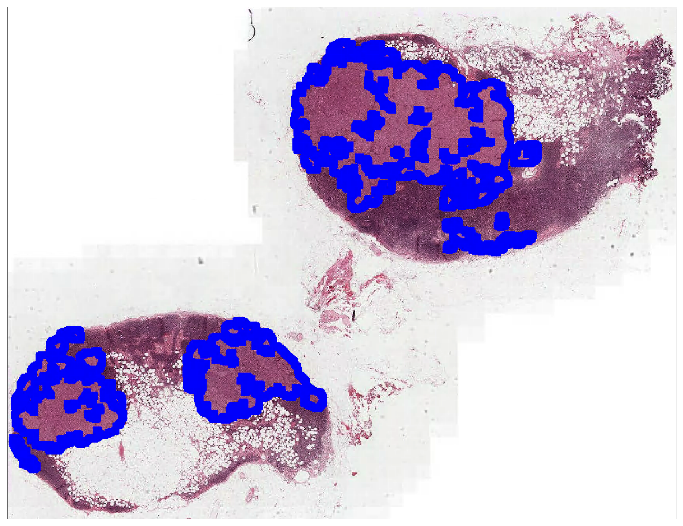

In [130]:
# Raw image with annotation

fig = plt.figure(figsize=(12, 12))
test_040a = np.array(Image.open('test_040_annotated.png'))
plt.imshow(test_040a)
plt.axis('off')
plt.show()

### Test WSI #21

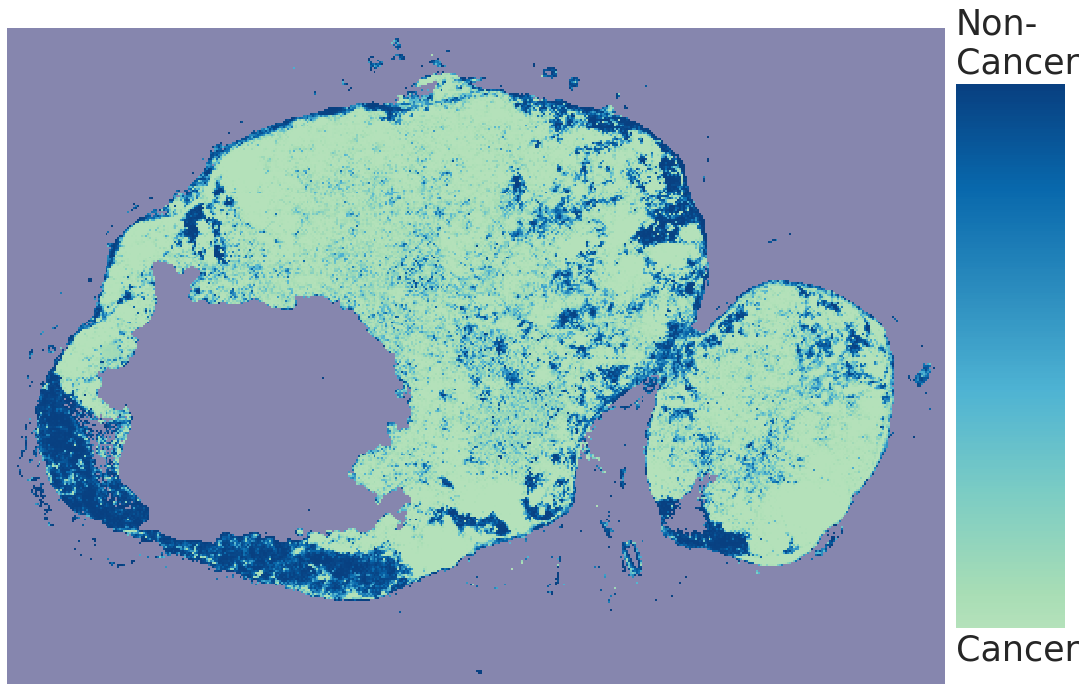

In [131]:
v.make_heatmap('test_021', predictions_021, 54,
               shrink=.5, aspect=5, rotate=True)

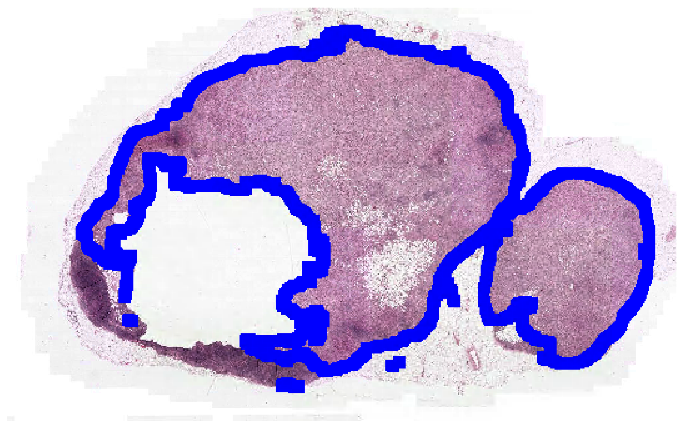

In [132]:
# Raw image with annotation

fig = plt.figure(figsize=(12, 12))
test_021a = np.array(Image.open('test_021_annotated.png'))
plt.imshow(np.rot90(test_021a))
plt.axis('off')
plt.show()

### Test WSI #27

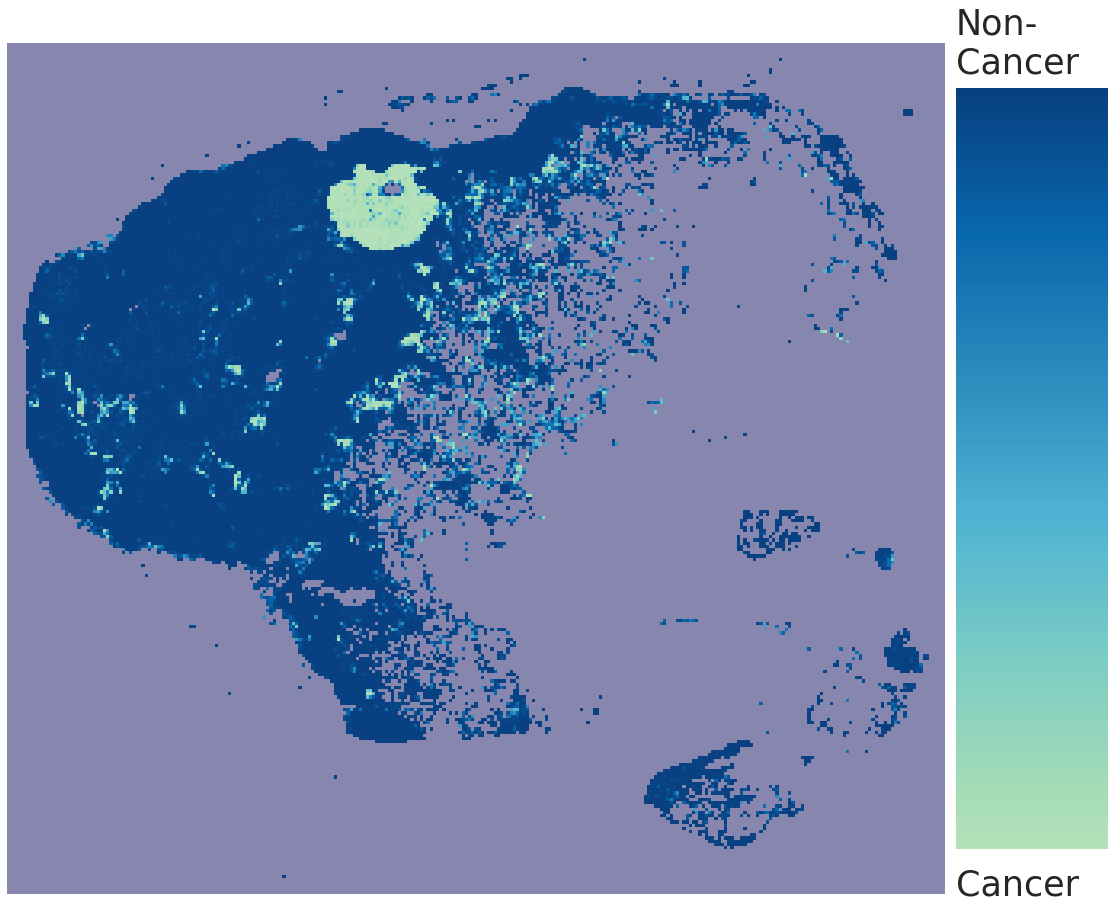

In [133]:
v.make_heatmap('test_027', predictions_027, 56,
               shrink=.7, aspect=5, rotate=True)

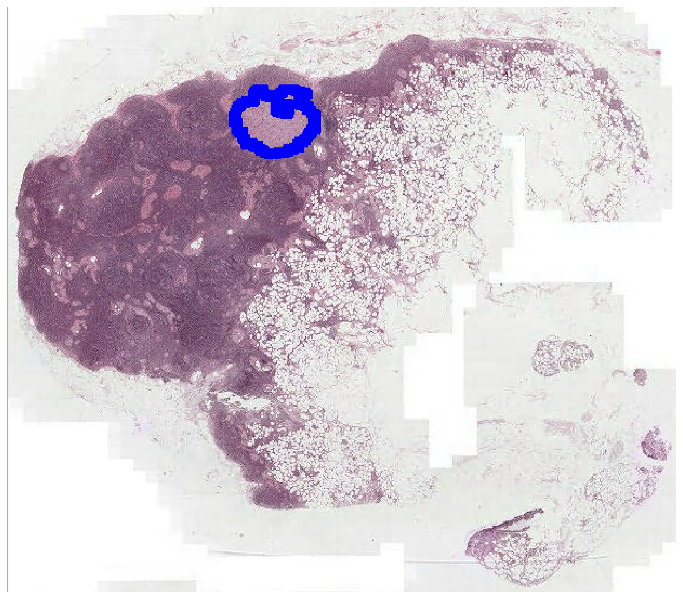

In [134]:
# Raw image with annotation

fig = plt.figure(figsize=(12, 12))
test_027a = np.array(Image.open('test_027_annotated.png'))
plt.imshow(np.rot90(test_027a))
plt.axis('off')
plt.show()